In [1]:
import pandas as pd
import numpy as np
import pickle
import itertools
import gc
import math
import matplotlib.pyplot as plt
import dateutil.easter as easter
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
from datetime import datetime, date, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge, Lasso

In [2]:
original_train_df = pd.read_csv('C:\\Users\\user\\kaggle_playground\\data\\train.csv')
original_test_df = pd.read_csv('C:\\Users\\user\\kaggle_playground\\data\\test.csv')
gdf_df = pd.read_csv('C:\\Users\\user\\kaggle_playground\\data\\GDP_data_2015_to_2019_Finland_Norway_Sweden.csv')
submission_df = pd.read_csv('C:\\Users\\user\\kaggle_playground\\data\\sample_submission.csv')

In [3]:
gdf_df.head()

,year,GDP_Finland,GDP_Norway,GDP_Sweden
0,2015,234.440,385.802,505.104
1,2016,240.608,368.827,515.655
2,2017,255.017,398.394,541.019
3,2018,275.580,437.000,555.455
4,2019,268.782,405.510,533.880


In [4]:
gdf_df.set_index('year', inplace=True)

In [5]:
gdf_df.head()

,GDP_Finland,GDP_Norway,GDP_Sweden
year,,,
2015,234.440,385.802,505.104
2016,240.608,368.827,515.655
2017,255.017,398.394,541.019
2018,275.580,437.000,555.455
2019,268.782,405.510,533.880


In [6]:
original_train_df.head()

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


In [7]:
original_test_df.head()

,row_id,date,country,store,product
0,26298,2019-01-01,Finland,KaggleMart,Kaggle Mug
1,26299,2019-01-01,Finland,KaggleMart,Kaggle Hat
2,26300,2019-01-01,Finland,KaggleMart,Kaggle Sticker
3,26301,2019-01-01,Finland,KaggleRama,Kaggle Mug
4,26302,2019-01-01,Finland,KaggleRama,Kaggle Hat


In [7]:
submission_df.head()

,row_id,num_sold
0,26298,100
1,26299,100
2,26300,100
3,26301,100
4,26302,100


In [8]:
original_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26298 entries, 0 to 26297
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    26298 non-null  int64 
 1   date      26298 non-null  object
 2   country   26298 non-null  object
 3   store     26298 non-null  object
 4   product   26298 non-null  object
 5   num_sold  26298 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.2+ MB


In [15]:
# THE DATE IS READ AS STRING MUST CONVERT TO DATE
for df in [original_train_df, original_test_df]:
    df['date'] = pd.to_datetime(df['date'])

  

In [10]:
original_train_df.head()

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


In [11]:
def smape_loss(y_true, y_pred):
    return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200

In [12]:
#feature engineering
def engineer(df):
    """Return a new dataframe with the engineered features"""
    
    def get_gdp(row):
        country = 'GDP_' + row.country
        return gdf_df.loc[row.date.year, country]
        
    new_df = pd.DataFrame({'gdp': np.log(df.apply(get_gdp, axis=1)),
                           'wd4': df.date.dt.weekday == 4, # Friday
                           'wd56': df.date.dt.weekday >= 5, # Saturday and Sunday
                          })

    # One-hot encoding (no need to encode the last categories)
    for country in ['Finland', 'Norway']:
        new_df[country] = df.country == country
    new_df['KaggleRama'] = df.store == 'KaggleRama'
    for product in ['Kaggle Mug', 'Kaggle Hat']:
        new_df[product] = df['product'] == product
        
    # Seasonal variations (Fourier series)
    # The three products have different seasonal patterns
    dayofyear = df.date.dt.dayofyear
    for k in range(1, 3):
        new_df[f'sin{k}'] = np.sin(dayofyear / 365 * 2 * math.pi * k)
        new_df[f'cos{k}'] = np.cos(dayofyear / 365 * 2 * math.pi * k)
        new_df[f'mug_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle Mug']
        new_df[f'mug_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle Mug']
        new_df[f'hat_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle Hat']
        new_df[f'hat_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle Hat']

    return new_df

      
      

      

      





In [13]:
train_df = engineer(original_train_df)
train_df['date'] = original_train_df.date
train_df['num_sold'] = original_train_df.num_sold.astype(np.float32)
test_df = engineer(original_test_df)

features = test_df.columns

for df in [train_df, test_df]:
    df[features] = df[features].astype(np.float32)
print(list(features))

['gdp', 'wd4', 'wd56', 'Finland', 'Norway', 'KaggleRama', 'Kaggle Mug', 'Kaggle Hat', 'sin1', 'cos1', 'mug_sin1', 'mug_cos1', 'hat_sin1', 'hat_cos1', 'sin2', 'cos2', 'mug_sin2', 'mug_cos2', 'hat_sin2', 'hat_cos2']


In [14]:
#Scale the data, fit a model, plot the training history and validate the model
def fit_model(X_tr, X_va=None, outliers=False):
    """Fit a model and return the training history"""
    start_time = datetime.now()

    # Preprocess the data
    X_tr_f = X_tr[features]
    preproc = StandardScaler()
    X_tr_f = preproc.fit_transform(X_tr_f)
    y_tr = X_tr.num_sold.values.reshape(-1, 1)
    
    # Train the model
    #model = LinearRegression()
    #model = HuberRegressor(epsilon=1.20, max_iter=500)
    model = Ridge()
    model.fit(X_tr_f, np.log(y_tr).ravel())

    if X_va is not None:
        # Preprocess the validation data
        X_va_f = X_va[features]
        X_va_f = preproc.transform(X_va_f)
        y_va = X_va.num_sold.values.reshape(-1, 1)
        # Inference for validation
        y_va_pred = np.exp(model.predict(X_va_f)).reshape(-1, 1)
        oof.update(pd.Series(y_va_pred.ravel(), index=X_va.index))
        
        # Evaluation: Execution time and SMAPE
        smape_before_correction = np.mean(smape_loss(y_va, y_va_pred))
        #y_va_pred *= LOSS_CORRECTION
        smape = np.mean(smape_loss(y_va, y_va_pred))
        print(f"Fold {run}.{fold} | {str(datetime.now() - start_time)[-12:-7]}"
              f" | SMAPE: {smape:.5f}   (before correction: {smape_before_correction:.5f})")
        score_list.append(smape)
        
        # Plot y_true vs. y_pred
        if fold == 0:
            plt.figure(figsize=(10, 10))
            plt.scatter(y_va, y_va_pred, s=1, color='r')
            #plt.scatter(np.log(y_va), np.log(y_va_pred), s=1, color='g')
            plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.xlim()[0], plt.xlim()[1]], '--', color='k')
            plt.gca().set_aspect('equal')
            plt.xlabel('y_true')
            plt.ylabel('y_pred')
            plt.title('OOF Predictions')
            plt.show()
        
    return preproc, model


In [17]:
preproc, model = fit_model(train_df)

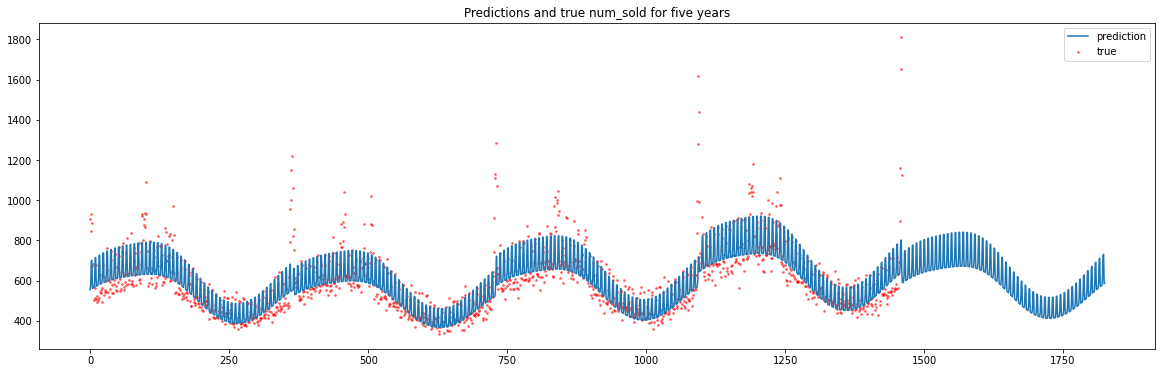

In [18]:
def plot_five_years_combination(engineer, country='Norway', store='KaggleMart', product='Kaggle Hat'):
    demo_df = pd.DataFrame({'row_id': 0,
                            'date': pd.date_range('2015-01-01', '2019-12-31', freq='D'),
                            'country': country,
                            'store': store,
                            'product': product})
    demo_df.set_index('date', inplace=True, drop=False)
    demo_df = engineer(demo_df)
    demo_df['num_sold'] = np.exp(model.predict(preproc.transform(demo_df[features])))
    plt.figure(figsize=(20, 6))
    plt.plot(np.arange(len(demo_df)), demo_df.num_sold, label='prediction')
    train_subset = train_df[(original_train_df.country == country) & (original_train_df.store == store) & (original_train_df['product'] == product)]
    plt.scatter(np.arange(len(train_subset)), train_subset.num_sold, label='true', alpha=0.5, color='red', s=3)
    plt.legend()
    plt.title('Predictions and true num_sold for five years')
    plt.show()

plot_five_years_combination(engineer)

        

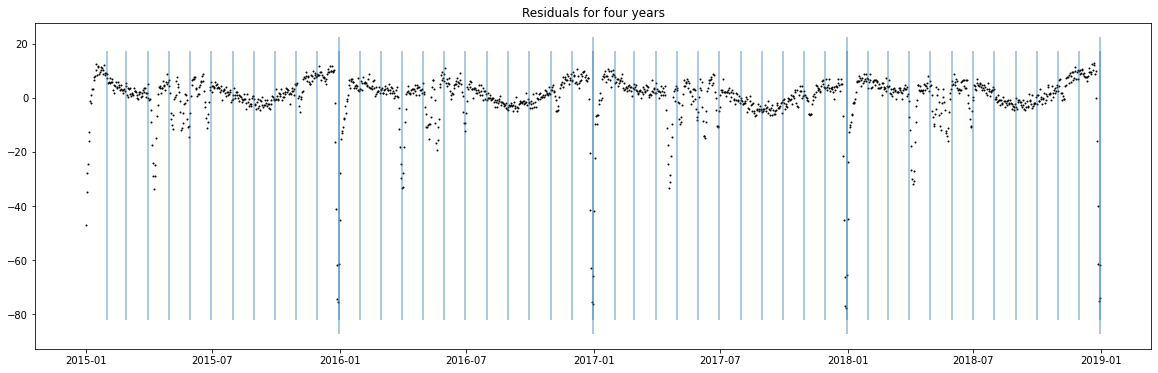

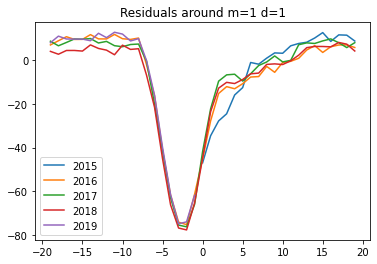

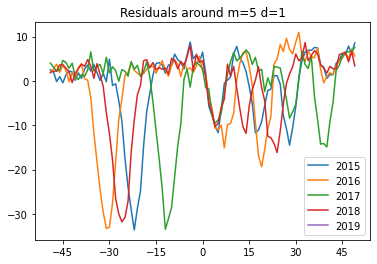

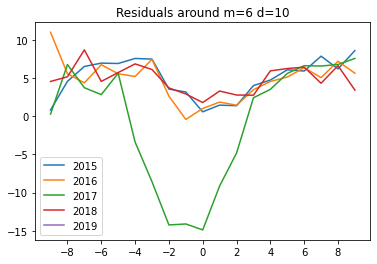

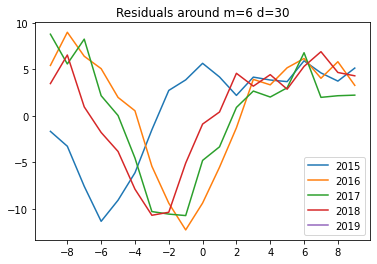

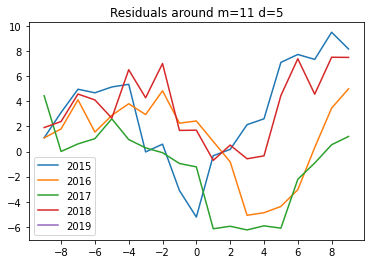

In [19]:
train_df['pred'] = np.exp(model.predict(preproc.transform(train_df[features])))
by_date = train_df.groupby(train_df['date'])
residuals = (by_date.pred.sum() - by_date.num_sold.sum()) / (by_date.pred.sum() + by_date.num_sold.sum()) * 200

# Plot all residuals (four-year range, sum of all products)
def plot_all_residuals(residuals):
    plt.figure(figsize=(20,6))
    plt.scatter(residuals.index,
                residuals,
                s=1, color='k')
    plt.vlines(pd.date_range('2015-01-01', '2019-01-01', freq='M'),
               plt.ylim()[0], plt.ylim()[1], alpha=0.5)
    plt.vlines(pd.date_range('2015-01-01', '2019-01-01', freq='Y'),
               plt.ylim()[0], plt.ylim()[1], alpha=0.5)
    plt.title('Residuals for four years')
    plt.show()
    
plot_all_residuals(residuals)

# Plot residuals for interesting intervals
def plot_around(residuals, m, d, w):
    """Plot residuals in an interval of with 2*w around month=m and day=d"""
    plt.figure()
    plt.title(f"Residuals around m={m} d={d}")
    for y in np.arange(2015, 2020):
        d0 = pd.Timestamp(date(y, m, d))
        residual_range = residuals[(residuals.index > d0 - timedelta(w)) & 
                                   (residuals.index < d0 + timedelta(w))]
        plt.plot([(r - d0).days for r in residual_range.index], residual_range, label=str(y))
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # only integer labels
    plt.legend()
    plt.show()

plot_around(residuals, 1, 1, 20) # end of year peak
plot_around(residuals, 5, 1, 50) # three moveable peaks depending on Easter
#plot_around(residuals, 5, 21, 10) # zoom-in
#plot_around(residuals, 5, 31, 15) # zoom-in
plot_around(residuals, 6, 10, 10) # first half of June (with overlay of Pentecost in 2017)
plot_around(residuals, 6, 30, 10) # moveable peak end of June
plot_around(residuals, 11, 5, 10) # moveable peak beginning of November

In [20]:
# more feature engineering(advanced model)
def engineer_more(df):
    """Return a new dataframe with more engineered features"""
    new_df = engineer(df)

    # End of year
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d)
                                      for d in range(24, 32)}),
                        pd.DataFrame({f"n-dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Norway')
                                      for d in range(24, 32)}),
                        pd.DataFrame({f"f-jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Finland')
                                      for d in range(1, 14)}),
                        pd.DataFrame({f"jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Norway')
                                      for d in range(1, 10)}),
                        pd.DataFrame({f"s-jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Sweden')
                                      for d in range(1, 15)})],
                       axis=1)
    
    # May
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"may{d}":
                                      (df.date.dt.month == 5) & (df.date.dt.day == d) 
                                      for d in list(range(1, 10))}), #  + list(range(17, 25))
                        pd.DataFrame({f"may{d}":
                                      (df.date.dt.month == 5) & (df.date.dt.day == d) & (df.country == 'Norway')
                                      for d in list(range(19, 26))})],
                       axis=1)
    
    # June and July
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"june{d}":
                                      (df.date.dt.month == 6) & (df.date.dt.day == d) & (df.country == 'Sweden')
                                      for d in list(range(8, 14))}),
                        #pd.DataFrame({f"june{d}":
                        #              (df.date.dt.month == 6) & (df.date.dt.day == d) & (df.country == 'Norway')
                        #              for d in list(range(22, 31))}),
                        #pd.DataFrame({f"july{d}":
                        #              (df.date.dt.month == 7) & (df.date.dt.day == d) & (df.country == 'Norway')
                        #              for d in list(range(1, 3))})],
                       ],
                       axis=1)
    
    # Last Wednesday of June
    wed_june_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-06-24')),
                                         2016: pd.Timestamp(('2016-06-29')),
                                         2017: pd.Timestamp(('2017-06-28')),
                                         2018: pd.Timestamp(('2018-06-27')),
                                         2019: pd.Timestamp(('2019-06-26'))})
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"wed_june{d}": 
                                      (df.date - wed_june_date == np.timedelta64(d, "D")) & (df.country != 'Norway')
                                      for d in list(range(-4, 6))})],
                       axis=1)
    
    # First Sunday of November
    sun_nov_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-11-1')),
                                         2016: pd.Timestamp(('2016-11-6')),
                                         2017: pd.Timestamp(('2017-11-5')),
                                         2018: pd.Timestamp(('2018-11-4')),
                                         2019: pd.Timestamp(('2019-11-3'))})
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"sun_nov{d}": 
                                      (df.date - sun_nov_date == np.timedelta64(d, "D")) & (df.country != 'Norway')
                                      for d in list(range(0, 9))})],
                       axis=1)
    
    # First half of December (Independence Day of Finland, 6th of December)
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Finland')
                                      for d in list(range(6, 14))})],
                       axis=1)

    # Easter
    easter_date = df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"easter{d}": 
                                      (df.date - easter_date == np.timedelta64(d, "D"))
                                      for d in list(range(-2, 11)) + list(range(40, 48)) + list(range(50, 59))})],
                       axis=1)
    
    return new_df.astype(np.float32)

train_df = engineer_more(original_train_df)
train_df['date'] = original_train_df.date
train_df['num_sold'] = original_train_df.num_sold.astype(np.float32)
test_df = engineer_more(original_test_df)

features = list(test_df.columns)
print(list(features))



['gdp', 'wd4', 'wd56', 'Finland', 'Norway', 'KaggleRama', 'Kaggle Mug', 'Kaggle Hat', 'sin1', 'cos1', 'mug_sin1', 'mug_cos1', 'hat_sin1', 'hat_cos1', 'sin2', 'cos2', 'mug_sin2', 'mug_cos2', 'hat_sin2', 'hat_cos2', 'dec24', 'dec25', 'dec26', 'dec27', 'dec28', 'dec29', 'dec30', 'dec31', 'n-dec24', 'n-dec25', 'n-dec26', 'n-dec27', 'n-dec28', 'n-dec29', 'n-dec30', 'n-dec31', 'f-jan1', 'f-jan2', 'f-jan3', 'f-jan4', 'f-jan5', 'f-jan6', 'f-jan7', 'f-jan8', 'f-jan9', 'f-jan10', 'f-jan11', 'f-jan12', 'f-jan13', 'jan1', 'jan2', 'jan3', 'jan4', 'jan5', 'jan6', 'jan7', 'jan8', 'jan9', 's-jan1', 's-jan2', 's-jan3', 's-jan4', 's-jan5', 's-jan6', 's-jan7', 's-jan8', 's-jan9', 's-jan10', 's-jan11', 's-jan12', 's-jan13', 's-jan14', 'may1', 'may2', 'may3', 'may4', 'may5', 'may6', 'may7', 'may8', 'may9', 'may19', 'may20', 'may21', 'may22', 'may23', 'may24', 'may25', 'june8', 'june9', 'june10', 'june11', 'june12', 'june13', 'wed_june-4', 'wed_june-3', 'wed_june-2', 'wed_june-1', 'wed_june0', 'wed_june1', 

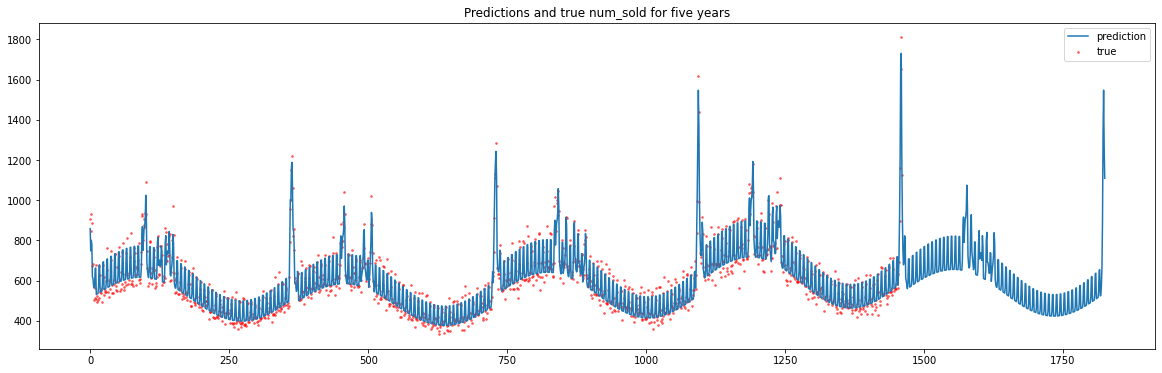

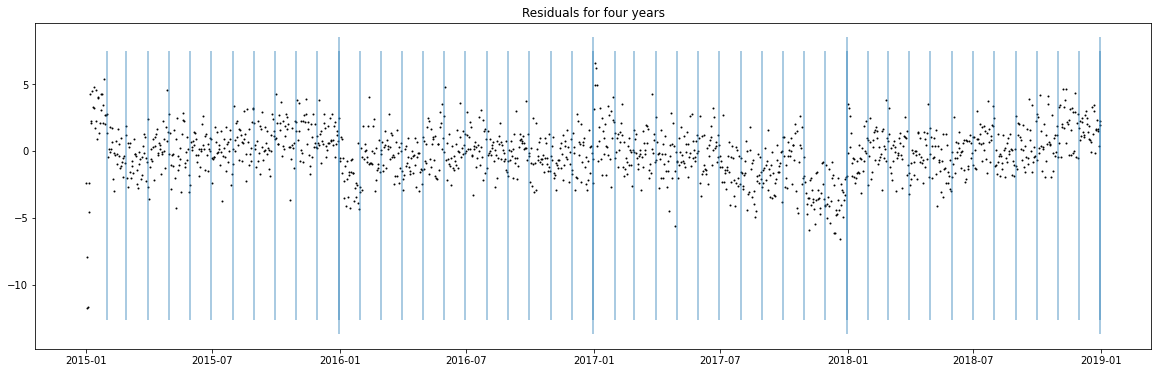

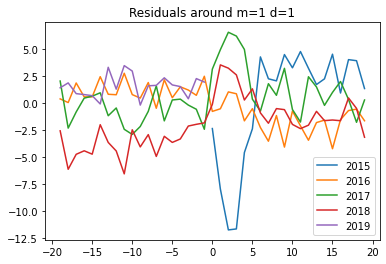

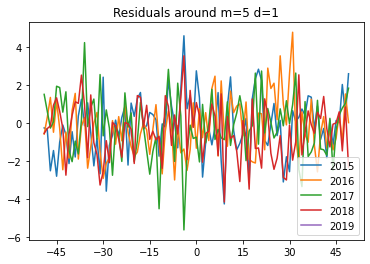

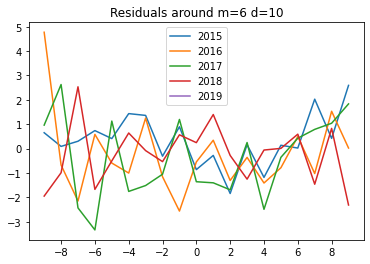

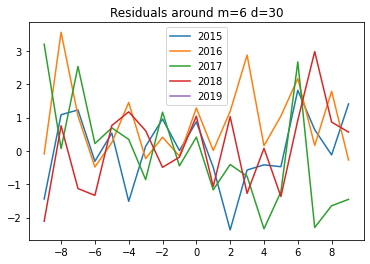

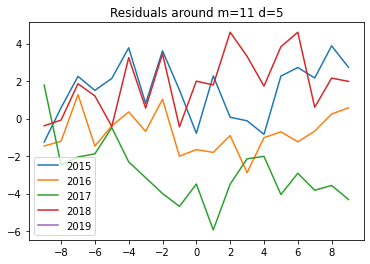

In [21]:
# residual of the advanc mode
preproc, model = fit_model(train_df)
train_df['pred'] = np.exp(model.predict(preproc.transform(train_df[features])))
with open('train_pred.pickle', 'wb') as handle: pickle.dump(train_df.pred, handle) # save residuals for further analysis
by_date = train_df.groupby(train_df['date'])
residuals = (by_date.pred.sum() - by_date.num_sold.sum()) / (by_date.pred.sum() + by_date.num_sold.sum()) * 200

# Plot all num_sold_true and num_sold_pred (five years) for one country-store-product combination
plot_five_years_combination(engineer_more)

# Plot all residuals (four-year range, sum of all products)
plot_all_residuals(residuals)

# Plot residuals for interesting intervals
plot_around(residuals, 1, 1, 20) # end of year peak
plot_around(residuals, 5, 1, 50) # three moveable peaks depending on Easter
#plot_around(residuals, 5, 21, 10) # zoom-in
#plot_around(residuals, 5, 31, 15) # zoom-in
plot_around(residuals, 6, 10, 10) # first half of June (with overlay of Pentecost in 2017)
plot_around(residuals, 6, 30, 10) # moveable peak end of June
plot_around(residuals, 11, 5, 10) # moveable peak beginning of November

Fold 0.0
Fold 0.0 | 00:00 | SMAPE: 4.16880   (before correction: 4.16880)


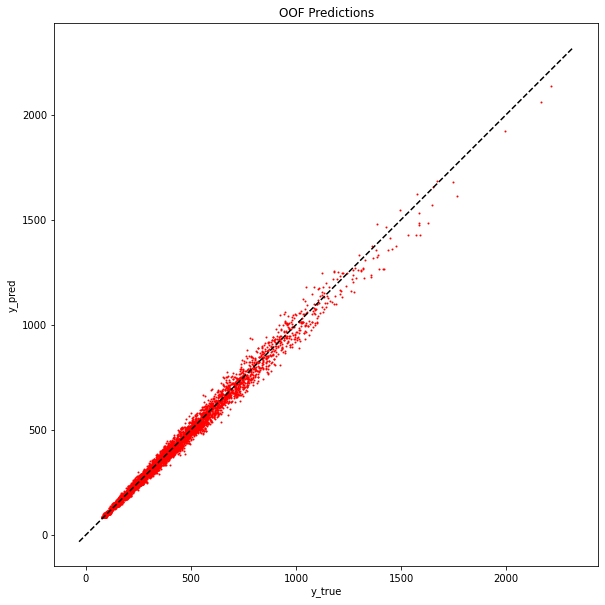

Fold 0.1
Fold 0.1 | 00:00 | SMAPE: 4.34682   (before correction: 4.34682)
Fold 0.2
Fold 0.2 | 00:00 | SMAPE: 4.42114   (before correction: 4.42114)
Fold 0.3
Fold 0.3 | 00:00 | SMAPE: 4.40821   (before correction: 4.40821)
Average SMAPE: 4.33624


In [22]:
#%%time
RUNS = 1 # should be 1. increase the number of runs only if you want see how the result depends on the random seed
OUTLIERS = True
TRAIN_VAL_CUT = datetime(2018, 1, 1)
LOSS_CORRECTION = 1

# Make the results reproducible
np.random.seed(202100)

total_start_time = datetime.now()
oof = pd.Series(0.0, index=train_df.index)
score_list = []
for run in range(RUNS):
    kf = GroupKFold(n_splits=4)
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_df, groups=train_df.date.dt.year)):
        X_tr = train_df.iloc[train_idx]
        X_va = train_df.iloc[val_idx]
        print(f"Fold {run}.{fold}")
        preproc, model = fit_model(X_tr, X_va)

print(f"Average SMAPE: {sum(score_list) / len(score_list):.5f}")
with open('oof.pickle', 'wb') as handle: pickle.dump(oof, handle)

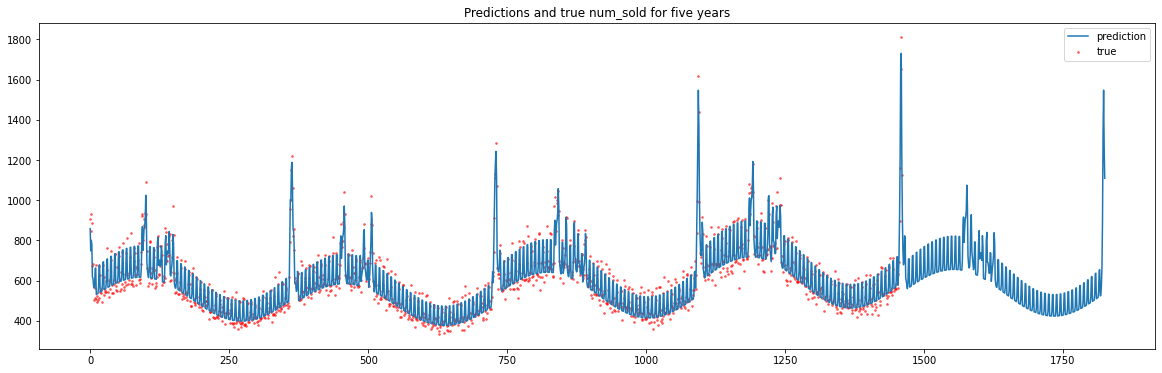

In [23]:
# Fit the model on the complete training data
train_idx = np.arange(len(train_df))
X_tr = train_df.iloc[train_idx]
preproc, model = fit_model(X_tr, None)

plot_five_years_combination(engineer_more) # Quick check for debugging

# Inference for test
test_pred_list = []
test_pred_list.append(np.exp(model.predict(preproc.transform(test_df[features]))) * LOSS_CORRECTION)

# Create the submission file
sub = original_test_df[['row_id']].copy()
sub['num_sold'] = sum(test_pred_list) / len(test_pred_list)
sub.to_csv('submission_linear_model.csv', index=False)